# Elastic Net Evaluation

This notebook trains **ElasticNet regression models per drug** using gene expression features.  
ElasticNet combines L1 (Lasso) and L2 (Ridge) regularization. We use `ElasticNetCV` to tune hyperparameters using 5-fold cross-validation.

Elastic Net combines both:
- **L1 regularization** (Lasso) → promotes sparsity
- **L2 regularization** (Ridge) → stabilizes coefficients

This allows it to both regularize and select features, making it a simple but powerful linear model.

We evaluate performance using:
- **RMSE (Root Mean Squared Error)**
- **R² (Coefficient of Determination)**

and visualize their **distribution across all drugs**.


In [7]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
DATA_PATH = "../../../data/pseudo_bulk/gdsc_cell_drug_with_pca.parquet"
data = pd.read_parquet(DATA_PATH)

print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (571985, 13)


## 1. Compute Metrics per Drug

For each drug:
- Select only rows where that drug was tested
- Split the data into training and test sets
- Fit an **Elastic Net** regressor on the PCA features
- Evaluate on test set with **RMSE** and **R²**

We only include drugs with **≥ 10 samples** to ensure meaningful evaluation.


In [9]:
os.makedirs("results", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 10:
        continue

    X = df[gene_cols].values
    y = df["LN_IC50"].values

    model = ElasticNetCV(
        alphas=[0.01, 0.1, 1.0, 10.0],
        l1_ratio=[0.1, 0.5, 0.9],
        cv=kf,
        max_iter=5000,
        random_state=42
    )
    model.fit(X, y)

    # CV Performance
    rmse_scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf)
    r2_scores = cross_val_score(model, X, y, scoring="r2", cv=kf)

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "alpha": model.alpha_,
        "l1_ratio": model.l1_ratio_,
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })



In [10]:
results_df = pd.DataFrame(results)
results_df.to_csv("results/elastic_net_results_cv.csv", index=False)

print("📁 Saved to results/elastic_net_results_cv.csv")
results_df.head()


📁 Saved to results/elastic_net_results_cv.csv


,DRUG_ID,n_samples,alpha,l1_ratio,rmse_mean,rmse_std,r2_mean,r2_std
0,1,391,10.0,0.9,1.104733,0.179223,-0.015195,0.034354
1,3,356,10.0,0.9,2.039933,0.236999,-0.053012,0.048141
2,5,394,10.0,0.9,1.657305,0.050236,-0.019389,0.089701
3,6,403,10.0,0.9,0.906001,0.077629,-0.050723,0.034702
4,9,396,10.0,0.9,1.493833,0.111596,-0.063978,0.111254


## 2. RMSE Distribution

We visualize the distribution of **RMSE** values across all drugs.

This shows how much prediction error the Elastic Net model makes on average, and how much it varies between drugs.


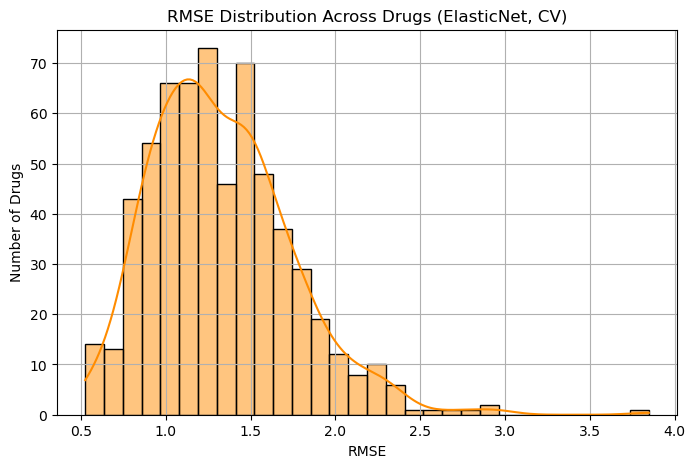

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title("RMSE Distribution Across Drugs (ElasticNet, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()

## 3. R² Distribution

This distribution shows how well Elastic Net explains the variance in IC50 values.

- **R² > 0** means the model is better than the mean predictor
- **R² = 1** would be a perfect model
- Drugs with **R² close to or < 0** may not be predictable using current features


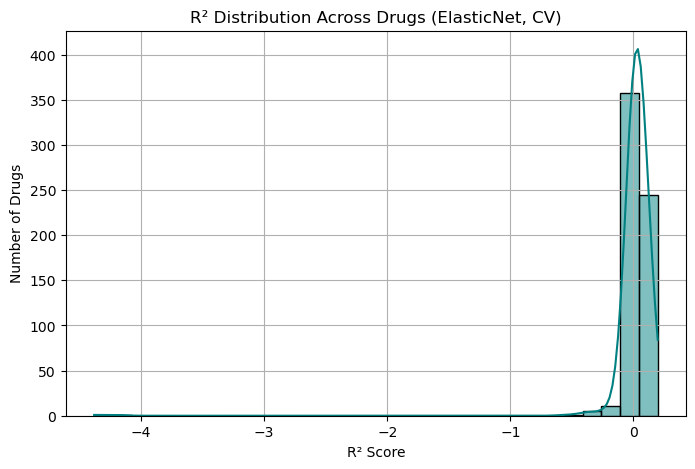

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title("R² Distribution Across Drugs (ElasticNet, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()

## 4. Summary

Elastic Net gives a more flexible alternative to linear regression models by combining L1 and L2 penalties.

From the plots above, we can see:
- The **average RMSE** and its spread across drugs
- The **R² values**, showing how well the model captures IC50 variance

This gives us a strong baseline for comparison with more complex models like XGBoost or neural networks.
